# Segmentation study

The task here is to perform a segmentation study on the provided dataset. The first few steps will be importing and cleaning the data (as we did in the prediction of income class exercise). We will first import the relevant modules. Since we are not interested in prediction here, we will combine the training and the test datasets and perform the segmentation study on the combined dataset. 

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from matplotlib.pyplot import figure
import numpy as np


raw_data_train = pd.read_csv('au_train.csv')
raw_data_test = pd.read_csv('au_test.csv')

y_train = raw_data_train.iloc[:,-1]
le = LabelEncoder()
codes_train, uniques_train = pd.factorize(y_train, sort=True)

y_test = raw_data_test.iloc[:,-1]
le = LabelEncoder()
codes_test, uniques_test = pd.factorize(y_test, sort=True)

print (codes_train, uniques_train)
print (codes_test, uniques_test)

codes_train = pd.DataFrame(codes_train,columns=['Output_class'])
codes_test = pd.DataFrame(codes_test,columns=['Output_class'])

all_y = pd.concat([codes_train, codes_test], axis=0)
print (all_y)


[0 0 0 ... 0 0 1] Index([' <=50K', ' >50K'], dtype='object')
[0 0 1 ... 0 0 1] Index([' <=50K.', ' >50K.'], dtype='object')
       Output_class
0                 0
1                 0
2                 0
3                 0
4                 0
5                 0
6                 0
7                 1
8                 1
9                 1
10                1
11                1
12                0
13                0
14                1
15                0
16                0
17                0
18                0
19                1
20                1
21                0
22                0
23                0
24                0
25                1
26                0
27                1
28                0
29                0
...             ...
16251             0
16252             1
16253             0
16254             1
16255             1
16256             0
16257             0
16258             0
16259             0
16260             0
16261             1
16262           

We can now just concatenate the y column to the combined dataset to identify correlations. 

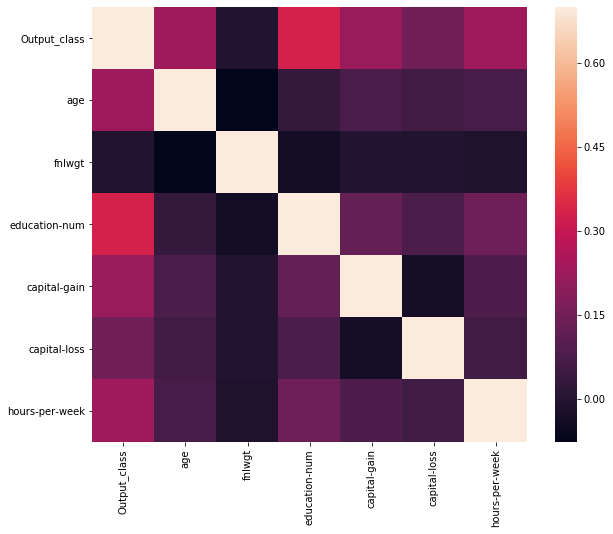

In [96]:
combined = pd.concat([raw_data_train, raw_data_test], axis=0)
test = pd.concat([all_y,combined],axis=1)

corrmat =  test.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corrmat, vmax=.7, square=True)
plt.show()


Again, we see that fnlwgt has no correlation with the output class (or with any other features), so we can safely remove it along with the eduction feature, which already has a representation numerically as education_num. And then, we will take a closer look at the different features. There's also a small discrepancy between the training and the test datasets in the way the output class is defined, and we will take care of that as well. 

In [97]:
combined = combined.drop(['fnlwgt', 'education'], axis=1)
combined.loc[combined['class'] == ' <=50K.', 'class'] = ' <=50K'
combined.loc[combined['class'] == ' >50K.', 'class'] = ' >50K'

combined.head(5)

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Now, we will make a few hypotheses about the dataset, both intuitively and using the above correlation plot. 
1. Age will likely be directly proportional to income class, since older people generally have more experience. 
2. Education_num will be directly proportional to income class. 
3. We can also expect hours-per-week and capital-gain to be directly correlated with whether someone makes more than 50K.
I am unsure about how the other features will correlate with the output class, but we can investigate each of them below. We will start with some histograms for age and education_num for the two output income classes. 

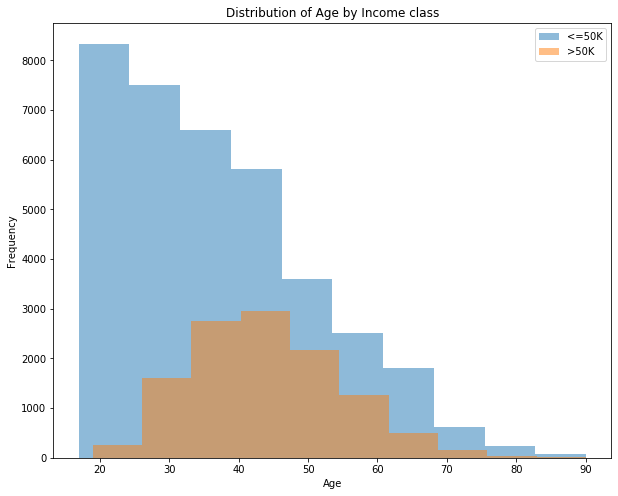

In [98]:
figure(figsize=(10,8))
plt.hist('age', data=combined[combined['class'] == ' <=50K'], alpha=0.5, label='<=50K');
plt.hist('age', data=combined[combined['class'] == ' >50K'], alpha=0.5, label='>50K');
plt.title('Distribution of Age by Income class');
plt.xlabel('Age');
plt.ylabel('Frequency');
plt.legend();

As expected, the older population have a much higher tendency to be in the >50K class. We will similarly look at education_num. 

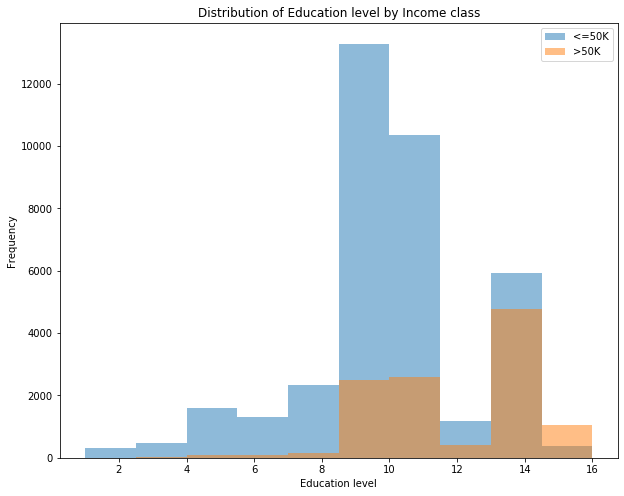

In [99]:
figure(figsize=(10,8))
plt.hist('education-num', data=combined[combined['class'] == ' <=50K'], alpha=0.5, label='<=50K');
plt.hist('education-num', data=combined[combined['class'] == ' >50K'], alpha=0.5, label='>50K');
plt.title('Distribution of Education level by Income class');
plt.xlabel('Education level');
plt.ylabel('Frequency');
plt.legend();

It looks like there's a disproportionately large number of people in the education-num=10 and 14, corresponding to high-school and college respectively. It would serve our purposes better if we plot these as bar graphs at discrete education-num levels as shown below. We will use seaborn for this. 

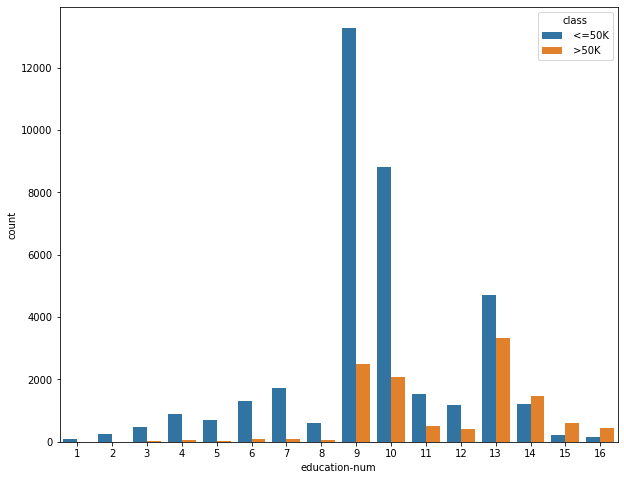

In [100]:
f, ax = plt.subplots(figsize=(10, 8))
sns.countplot(x="education-num", hue="class", data=combined)
plt.show()

This is a clear representation that the education level is directly proportional to income class.

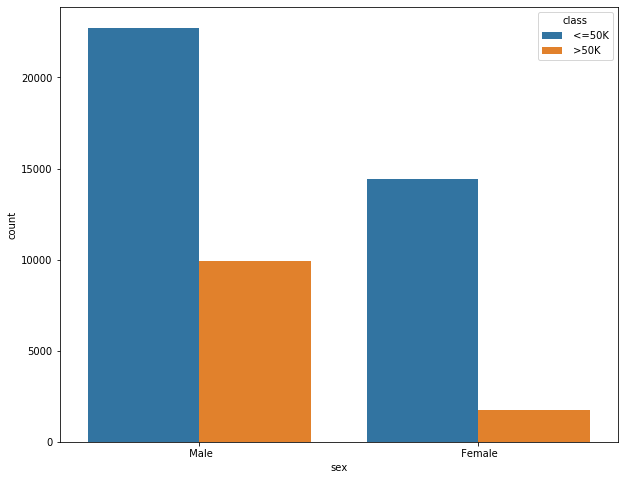

In [101]:
f, ax = plt.subplots(figsize=(10, 8))
sns.countplot(x="sex", hue="class", data=combined)
plt.show()

It's seen here that male members of the population are more likely to be earning >50K than females. 
One way to overcome the distribution variation in the different classes is to normalize the feature distribution as below. Seaborn does not have a ready means to do this, so we will have to find a workaround. 

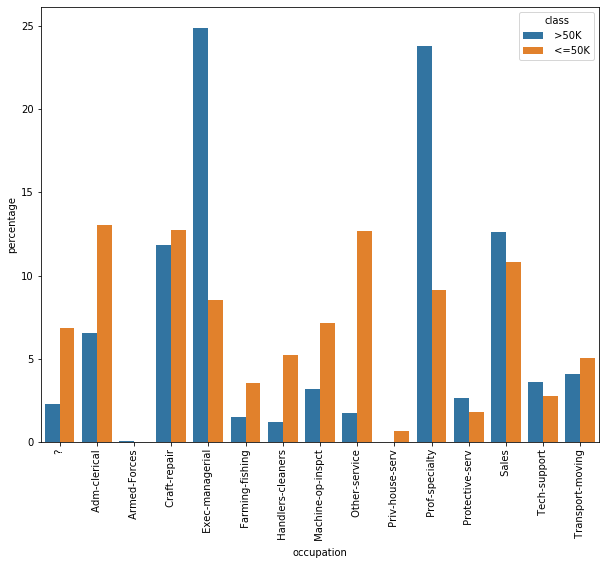

In [102]:
f, ax = plt.subplots(figsize=(10, 8))
occupation_counts = (combined.groupby(['class'])['occupation']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('occupation'))
p = sns.barplot(x="occupation", y="percentage", hue="class", data=occupation_counts)
_ = plt.setp(p.get_xticklabels(), rotation=90)  # Rotate labels

From the above, we see that certain professions are more likely to be earning >50K. Exec-managerial, prof-speciality, Sales and Tech-support all have higher likelihood of earning >50K. 

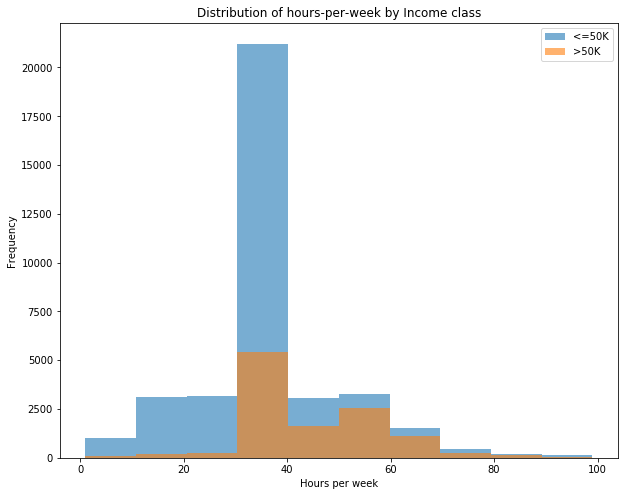

In [103]:
figure(figsize=(10,8))
plt.hist('hours-per-week', data=combined[combined['class'] == ' <=50K'], alpha=0.6, label='<=50K');
plt.hist('hours-per-week', data=combined[combined['class'] == ' >50K'], alpha=0.6, label='>50K');
plt.title('Distribution of hours-per-week by Income class');
plt.xlabel('Hours per week');
plt.ylabel('Frequency');
plt.legend();

The evidence is clear - more the number of hours, higher the chances of the person earning >50K. 
Curious to see the effect that relationship status has on the outcome. 

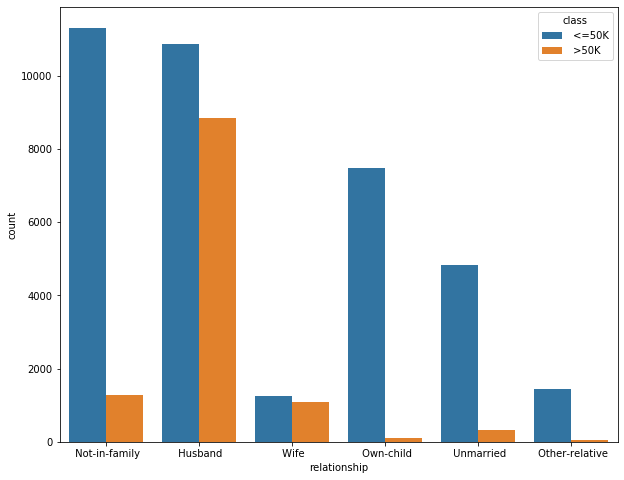

In [104]:
f, ax = plt.subplots(figsize=(10, 8))
sns.countplot(x="relationship", hue="class", data=combined)
plt.show()

In [105]:
foo = combined[(combined['relationship']==' Husband') | (combined['relationship'] == ' Wife')]
print ('Overall\n',combined['class'].value_counts(normalize=True) * 100)
print ('Husband or Wife\n',foo['class'].value_counts(normalize=True) * 100)

Overall
  <=50K    76.071823
 >50K     23.928177
Name: class, dtype: float64
Husband or Wife
  <=50K    54.919037
 >50K     45.080963
Name: class, dtype: float64


There seens to be a huge correlation between whether someone's in a relationship and their chances of earning >50K.
We will finally look at the distribution of income class by race to see if there's any correlation. 

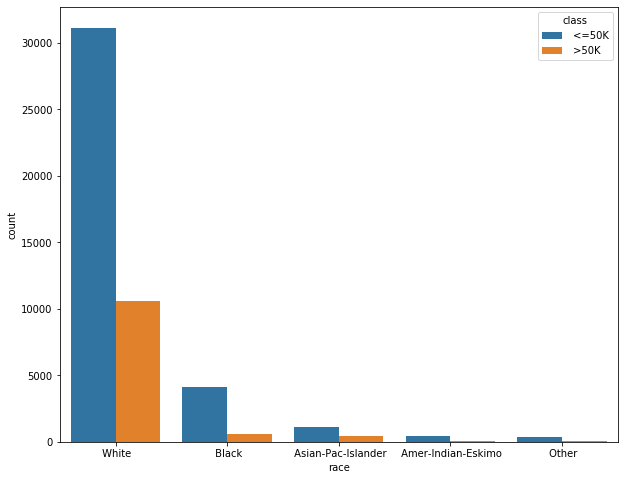

In [106]:
f, ax = plt.subplots(figsize=(10, 8))
sns.countplot(x="race", hue="class", data=combined)
plt.show()

There's some correlation here - white and Asian-Pac-Islander people tend to be more likely to earn >50K. 

# Conclusion

From our segmentation study, we obtained a few insights about the characteristics of the population that correlates with the income. Specifically, we arrived at the following conclusions:
1. Older members of the population are more likely to earn >50K. 
2. Males are more likely to earn >50K - 40% of all males earn >50K while only 16% of the females earn >50K. 
3. Education level and profession have a strong influence on the income. Exec-managerial, prof-speciality, Sales and Tech-support all have higher likelihood of earning >50K. 
4. Unsuprisingly, people who work longer hours have a higher likelihood of earning >50K.
5. Married people have a significantly higher chance (about 2 times more likely) of earning >50K. 
6. White and Asian-Pacific-Islanders tend to earn >50K more than other races. 